# Artifitial Inteligence: Evolutionary Algorithm
## Erasmus - Curse 2023-24

### Genetic Algorithm

                                              
                                             García Fernández, Helios - Winter, 2023.

## Basic Structure
To solve this problem, first we are going to write the bones of the structure that we could use to solve other differents problems. Then, we will develop these parts of the algorithm focusing on the Gioconda Problem, where we will try to use a genetic algorithm to create a image 

### Libraries
The libraries we are going to need to carry out this problem

In [ ]:
# 1.- numpy matrix representation
import numpy as np

# 2.- random to random values
import random, math

# 3.- PIL to read, draw and operate with images
from PIL import Image,ImageDraw, ImageChops
import imageio
# To Draw
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.figsize'] = (15,10) #resize the image

from skimage.metrics import structural_similarity as ssim



In [ ]:
#to avoid problems with "colour" from a different module
!pip uninstall colour
!pip uninstall colour-science
!pip install colour-science

#new fitness Delta E
import colour

### Data Structure
In this problem we are going to use the 'gioconda.jpg' as the original image. Firstly, We need to load the photo and represent it as an array with the numpy library due to prepare the data to use them.

In [195]:
#load the photo

original_image = 'gioconda.jpg'
img = Image.open(original_image).convert('RGBA')

In [196]:
colour

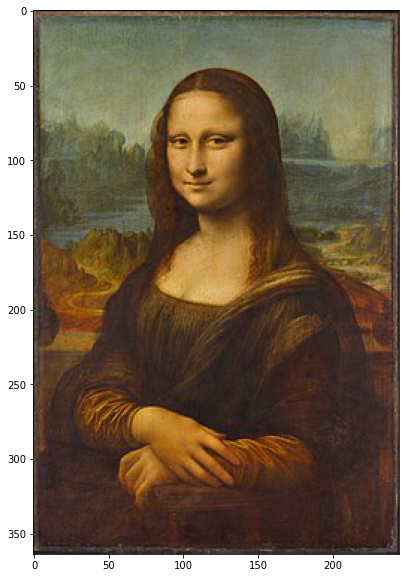

In [197]:
plt.imshow(img)

Now, we will transform the image to a matrix of values between 0 and 255 using numpy. It is important to notice that we are using a image with 4 different channels (RGBA). Because of this, we can differences 4 different matrix inside of the array.

In [198]:
IM4ARRAY = np.array(img)
OR_Image = IM4ARRAY

Saving the shape to be able to create more matrix with the same size. As we can observe, the fourth element of the tuple is "4" because of what we mention above.

In [199]:
im4array_shape = IM4ARRAY.shape

In [200]:
im4array_shape

(364, 245, 4)

### MAIN CONTROL PARAMETERS
Here we define the main constants that we will need for the genetic algorithm

In [408]:
# Number of Genes that make up an individual
NUM_GENES = 50

# Population Size
POPULATION_SIZE = 60

# Participants in a Tournament
NUM_PARTICIPANTS = 5

# Mutation rate
MUTATION_RATE = 0.2

# Portion of inviduals who are parents
CROSSOVER_RATE = 0.7

# Number of Iterations
STOP = 1000

# Print Step. Create the image of the best candidate after PRINT_STEP iterations
PRINT_STEP = 10



### GEN GENERATOR AND CANDIDATE GENERATOR
The funtion to create a single gene which will be inside of a chromosome. In our case, the gene will represent a triangle within the image to be reconstructed. Therefore, we will have to return as a result a tuple with enough data to be able to define an RGBA triangle without leaving the edges of the image. Since to generate a triangle we will use the ImageDraw class of PIL using the "polygon" function, we will only need to define 3 points in a two-dimensional space, in addition to 4 random values for each of the channels between 0 and 255 (x1,y1,x2,y2,x3,y3,c1,c2,c3,c4). 
At the end, the chromosome will be make up by NUM_GENES genes.

In [252]:
size_y,size_x,channels = im4array_shape #x,y is twisted with numpy
def gen_generator():
    x1,y1 = random.randrange(0,size_x),random.randrange(0,size_y)
    x2,y2 = random.randrange(0,size_x),random.randrange(0,size_y)
    x3,y3 = random.randrange(0,size_x),random.randrange(0,size_y)
    lDots = (x1,y1,x2,y2,x3,y3)
    lDots += tuple(random.randrange(0,255,random.randrange(1,10)) for _ in range(channels))
    return lDots

g1 = gen_generator()
g1

(62, 163, 94, 325, 37, 256, 76, 143, 252, 35)

Now, to be able to create a chromosome or candidate we just need to create a tuple with the number of random genes that we would like to have in every candidate.

In [253]:
def candidate_generator():
    return tuple(gen_generator() for _ in range(NUM_GENES))
c1 = candidate_generator()

### Decoder
With this funtion we could transform the candidate to an image and then to an array.

In [254]:
def decoder(candidate):
    im = Image.new('RGBA',(size_x,size_y))
    draw = ImageDraw.Draw(im)
    for (x1,y1,x2,y2,x3,y3,c1,c2,c3,c4) in candidate:
        draw.polygon([(x1,y1),(x2,y2),(x3,y3)], fill = (c1,c2,c3,c4))
        
    return im

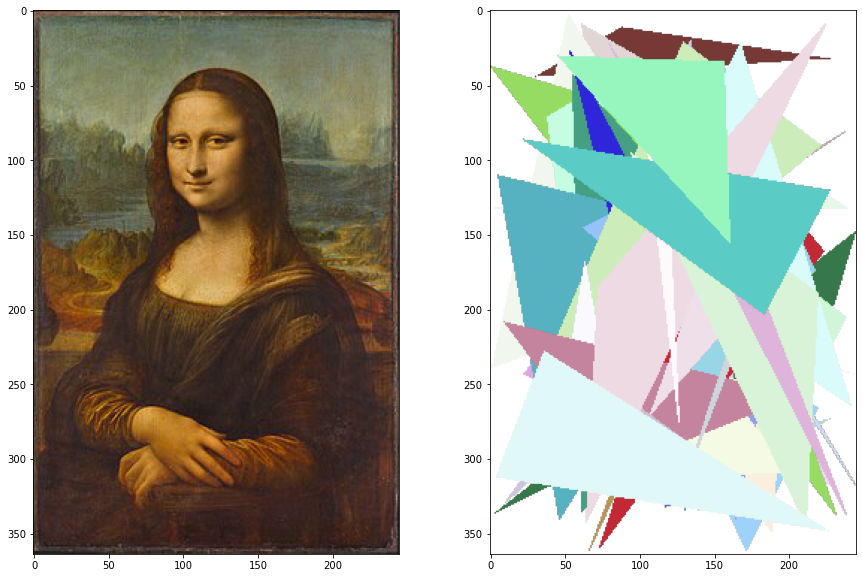

In [255]:
img_1 = decoder(c1)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(OR_Image)
axarr[1].imshow(img_1)

### Population
With the chromosome created, we just need to create our initial population with this chromosome

In [41]:
def initialize_population():
    return [candidate_generator() for _ in range(POPULATION_SIZE)]

### FITNESS
To achieve the comparison between the candidates in the population we need to create a funtion called "Fitness" which score how good the chromosome is. Therefore, we can use different fitness based on the problem that arises, but not all of them have to work equally well. We are going to use 3 different fitness, looking for the minimun error in the optimization search.

#### FITNESS SE
In this case, we calculate the error pixel-by-pixel bewteen the image created and the original



In [82]:
def fitnessP(candidate, show=False):
    dif = ImageChops.difference(decoder(candidate),img)
    if show:
        return np.sum(np.array(dif,dtype=np.uint8)),dif
    return np.sum(np.array(dif,dtype=np.uint8))

(38639965, <matplotlib.image.AxesImage at 0x7ff2302803d0>)

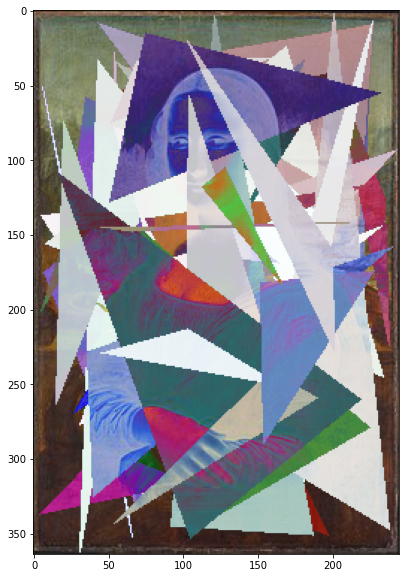

In [83]:
fTry = fitnessP(c1,True)
fTry[0],plt.imshow(fTry[1]) #let us see how the different btw two images is performed


#### FITNESS The structural similarity index measure (SSIM) 
Another fitness that we are going to try is the **SSIM**, that is a perception-based model that considers image degradation as *perceived change in structural information*. Structural information is the idea that the pixels have strong inter-dependencies especially when they are spatially close. These dependencies carry important information about the structure of the objects in the visual scene. 

In [71]:
def fitnessSSIM(ind):
    dec =  np.array(decoder(ind),dtype=np.uint8)
    return 1 - ssim(IM4ARRAY, dec, data_range=dec.max() - dec.min(),multichannel=True)

#### FITNESS Delta E
The last fitness uses the Delta E approach,it's a color difference metric that models the human eye, and is considered the standard measurement tool.

In [47]:
def fitnessColour(ind):
    dec = np.array(decoder(ind),dtype=np.uint8)
    return np.mean(colour.difference.delta_e.delta_E_CIE1976(IM4ARRAY, dec))

In [48]:
img1 = decoder(c1)
  

In [84]:
fSE = fitnessP(c1)
fN = fitnessN(c1)
fTryColour = fitnessColour(c1)
print(fSE,fTryColour,fN)

38639965 251.865821351 0.826730374414


Trying to improve the wide amount of calculations costs pending on the fitness, we will create a dictionary with the images related with the fitness. 

### Selection 
Of the different types of selection that we can choose, I have opted for the *tournament selection*. Giving a subset size of candidates, we create a random subset from the population and return the best individual from this subset.

In [95]:
def select_one_from_tournament(population, fit_dict, fit):
    minimun = float('inf') 
    for _ in range(NUM_PARTICIPANTS):
        candidate = random.choice(population)
        #check out what is on the dict
        if candidate in fit_dict:
            f_cand = fit_dict[candidate]
        else:
            f_cand = fit(candidate)
            fit_dict[candidate] = f_cand
        if f_cand < minimun:
            better = candidate
            minimun = f_cand
    return better,fit_dict

In [97]:
#example with the initial population and empty dict
i = select_one_from_tournament(initialize_population(),{},fitnessP)
decoder(i[0])
print(i[1][i[0]])

32313305


Now, we have a funtion able to select a certain best candidate from a random subset of the population, but we will need a subset of individuals selected in the same way.

In [98]:
def tournament_selection(population,num_selection, fit_dict,fit):
    fDict = fit_dict
    selection = []
    for i in range(num_selection):
        better,newDict = select_one_from_tournament(population,fit_dict,fit)
        selection.append(better)
        fDict = newDict
    return selection,fDict

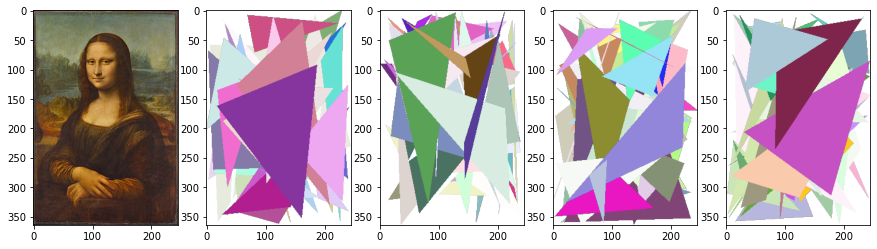

In [102]:
#looking for a selection of 5 better in tournament_selection
p = tournament_selection(initialize_population(),4,{},fitnessP)
count = 0
f, axarr = plt.subplots(1,5)
axarr[count].imshow(img)
for ima in p[0]:
    decoder(ima)
    axarr[count+1].imshow(decoder(ima))
    count+=1


### Crossover 
For the crossing between parents I have decided to carry out a *uniform crossing*. On it, each pair of genes is crossed independently. That is, instead of segmenting the pair of chromosomes and reunifying them, we randomly select gene by gene which of them will remain for the creation of the new chromosome.

In [103]:
def uniform_crossover(p1,p2):
    h1 = []
    h2 = []
    
    for i in range(len(p1)):
        if random.choice([True,False]):
            h1.append(p2[i])
            h2.append(p1[i])
        else:
            h1.append(p1[i])
            h2.append(p2[i])
            
    return [tuple(h1),tuple(h2)] #from the mix we create 2 new individuals

Giving a even list of parents it returns the offspring after the crossover

In [104]:
def offspring(parents):
    sons=[]
    for j in range(0,len(parents),2):
        sons.extend(uniform_crossover(*parents[j:j+2])) #we need to unpack parents to gived as 2 arguments
    return sons


### Mutation 
Using the MUTATION_RATE and giving a candidate and a number *n*, we will give the chance of mutation from a n number genes. In this case, mutation means change a gen to another new in the same chromosome.

In [105]:
def mutation_n(candidate,n):
    for _ in range(n):
        if random.random() < MUTATION_RATE:
            i = random.randrange(NUM_GENES)
            candidate = candidate[:i] + (gen_generator(),) + candidate[i+1:]
    return candidate       

Giving a certain *population* this funtion returns it mutated

In [106]:
def mutate_population(population,n):
    return [mutation_n(cand,n) for cand in population]


### New Generation 
To be able to create the new generation from the last population I decide to define the funtion *new_generation(population,n_parents,n_directs,fit_dict,fit)* where using the *tournament_selection* and a given number of parents and direct chromosome we build the next generation. At the end, directs will work as a remanent of "consistance" in the case where the search algorithm would be losts. Because of this, and the use of the dictionary, is better to mantain this values for some generations without any change just costing a low computational cost if these remanents are already in the dictionary. Thus, the offspring is just used for the real new chromosomes (sons).

In [107]:
def new_generation(population,n_parents,n_directs,n_genes_mutate,fit_dict,fit):
        parents, fDict1 = tournament_selection(population,n_parents,fit_dict,fit)
        directs, fDict2 = tournament_selection(population,n_directs,fDict1,fit)
        sons = offspring(parents)
        return fDict2, mutate_population(sons,n_genes_mutate)+directs

### Evolutionary Algorithm
Finally, we can define the genetic algorithm after define all the funtions that fill out this base.
In our algorithm we simply take a portion of the population defined by the *CROSSOVER_RATE* to be selected as parents, and the rest of the population will go directly to the next generation to maintain part of the successors.  Also, we decide a random number of gens to be mutated from the total number of gens (it will be change per generation) to engague the exploration. As we can see, Every time *PRINT_STEP* number of generations is reached, the selection of the best individual from that generation will be made using the dictionary that has been transferred from generation to generation to try to improve processing time (also, it let us to save the candidate as a picture and see it). As we can see, by not implementing any type of elitism until reaching that number of generations, there may be the possibility that in those intermediate generations the best candidate will be lost (although it may be passed through that number of direct populations). With this, we are tending towards exploration, although we ensure the best value saving it for the result.

In [409]:
import time
def genetic_algorithm(func,ini_population,t,it):
    start_time = time.perf_counter()

    
    if(len(ini_population) > 0):
        population = ini_population
    else: 
        population = initialize_population()
    
    dic = {}
    n_parents = round(POPULATION_SIZE * CROSSOVER_RATE) #the amount of population we considere with the CROSSOVER_RATE to make the offspring
    n_parents = (n_parents if n_parents%2==0 else n_parents-1) #we define above that the lenth of the subset of parents need to be a even number
    n_directs = POPULATION_SIZE - n_parents #the rest of the population will be directs as we said
    
    bests = []
    bests_ind = []
    for counter in range(STOP):
        n_genes_mutate = round(random.random()*NUM_GENES)
        if counter%PRINT_STEP == 0:
            print(counter)
            new_dict = {}
            actual = 'inicial'
            min = float('inf')
            for ind in population:
                f_ind = func(ind)
                new_dict[ind] = f_ind
                if f_ind < min:
                    actual = ind
                    min = f_ind
            best_img = decoder(actual)
            imageio.imwrite(t+it+'_gaN_{:>06}.png'.format(counter//PRINT_STEP),best_img)
            bests.append(min)
            bests_ind.append(best_img)
            dic, population = new_generation(population,n_parents,n_directs,n_genes_mutate,dic,func)
        else:
            dic, population = new_generation(population,n_parents,n_directs,n_genes_mutate,dic,func)
            print('.',end='')
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    return bests,elapsed_time,bests_ind

In [288]:
EAs_Solutions[1].append(1)
print(EAs_Solutions)
len(EAs_Solutions)

[[], [1, 1], []]


3

In [410]:
population = initialize_population().copy()
EAs_Solutions_ = [[],[],[]]
for i in range(5):
    EA_P = genetic_algorithm(fitnessP,population,"FitnessP","_it="+str(i))
    EA_SSIM = genetic_algorithm(fitnessSSIM,population,"fitnessSSIM","_it="+str(i))
    EA_E = genetic_algorithm(fitnessColour,population,"fitnessColour","_it="+str(i))
    sols = [EA_P,EA_SSIM,EA_E]
    print("--"*30+"it: "+str(i)+" Done"+"--"*30)
    for j in range(len(EAs_Solutions_)):
        EAs_Solutions_[j].append(sols[j])


0
.........10
.........20
.........30
.........40
.........50
.........60
.........70
.........80
.........90
.........100
.........110
.........120
.........130
.........140
.........150
.........160
.........170
.........180
.........190
.........200
.........210
.........220
.........230
.........240
.........250
.........260
.........270
.........280
.........290
.........300
.........310
.........320
.........330
.........340
.........350
.........360
.........370
.........380
.........390
.........400
.........410
.........420
.........430
.........440
.........450
.........460
.........470
.........480
.........490
.........500
.........510
.........520
.........530
.........540
.........550
.........560
.........570
.........580
.........590
.........600
.........610
.........620
.........630
.........640
.........650
.........660
.........670
.........680
.........690
.........700
.........710
.........720
.........730
.........740
.........750
.........760
.........770
......

In [411]:
 EAs_Solutions = EAs_Solutions_.copy()

In [390]:
worst_types = [0,0,0]
for i,fit in enumerate([fitnessP,fitnessSSIM,fitnessColour]):
    for p in population:
        cand = p
        f = fit(cand)
        if(worst_types[i] < f): worst_types[i]=f

In [391]:
print(worst_types)

[42989301, 0.8509000662599403, 273.33709141782788]


In [416]:
initial_Pop = population
worst_types = [0,0,0]
for i,fit in enumerate([fitnessP,fitnessSSIM,fitnessColour]):
    for p in initial_Pop:
        cand = p
        f = fit(cand)
        if(worst_types[i] < f): worst_types[i]=f
            
def plot_generations(EA,fit):
    norm = max(EA[0])
    #worst_norm = worst_types[t]
    fitnessY = EA[0] /norm
    
    generationsX = [i*PRINT_STEP for i in range(len(EA[0]))]
    return generationsX,fitnessY
def plot_time(EA,fit):
    norm = max(EA[0])
    #worst_norm = worst_types[t]
    fitnessY = EA[0]/norm
    
    A_time_per_step = EA[1]/PRINT_STEP
    generationsX = [i*A_time_per_step for i in range(len(EA[0]))]
    return generationsX,fitnessY


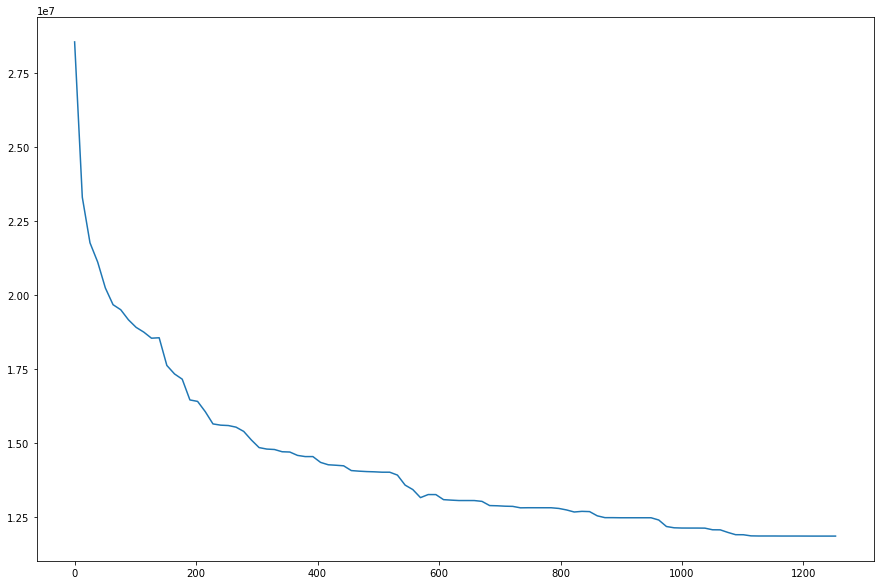

In [414]:
EA_P = EAs_Solutions[0][0]
plt.plot(*plot_time(EA_P,fitnessP))

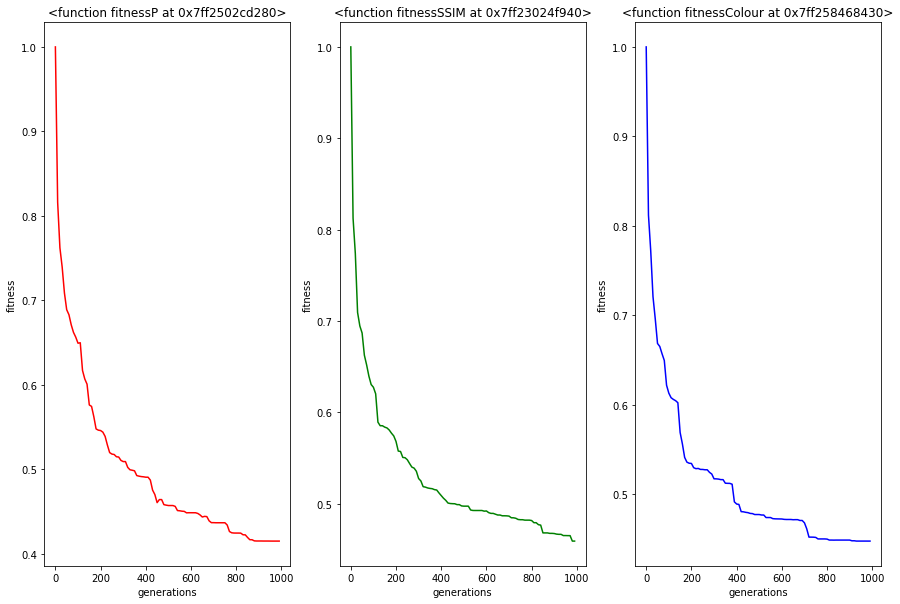

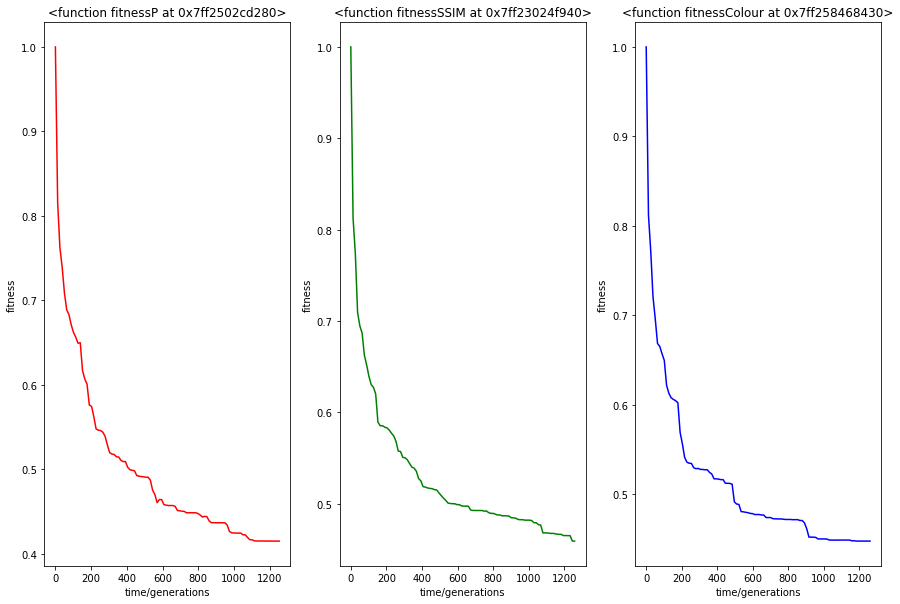

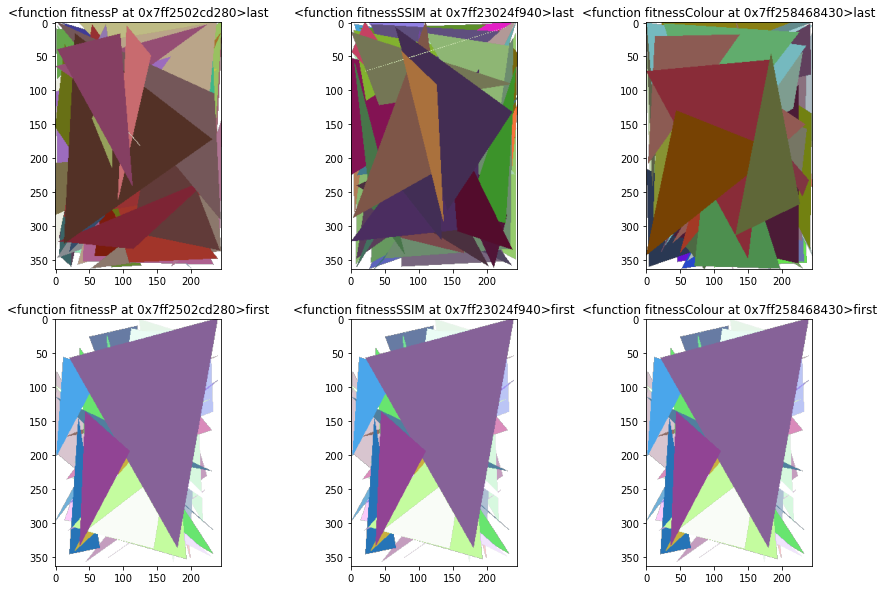

In [417]:
#GENERATIONS GRAPH
f, ax = plt.subplots(1,3)
EA_P,EA_SSIM,EA_E = EAs_Solutions[0][0],EAs_Solutions[0][1],EAs_Solutions[0][2] #To see how they look in one of the searchs
EAs = [EA_P,EA_SSIM,EA_E]
colours = ['r','g','b']
EAs_names = [fitnessP, fitnessSSIM,fitnessColour]
for i in range(3):
    x,y = plot_generations(EAs[i],EAs_names[i])
    ax[i].plot(x,y,color=colours[i])
    ax[i].set_ylabel('fitness')
    ax[i].set_xlabel('generations')
    ax[i].title.set_text(str(EAs_names[i]))
    
#TIME/GENERATIONS GRAPH
f, ax = plt.subplots(1,3)
EAs = [EA_P,EA_SSIM,EA_E]
colours = ['r','g','b']
EAs_names = [fitnessP, fitnessSSIM,fitnessColour]
for i in range(3):
    x,y = plot_time(EAs[i],EAs_names[i])
    ax[i].plot(x,y,color=colours[i])
    ax[i].set_ylabel('fitness')
    ax[i].set_xlabel('time/generations')
    ax[i].title.set_text(str(EAs_names[i]))
f, ax = plt.subplots(2,3)
EAs = [EA_P,EA_SSIM,EA_E]

#WORST/BEST CASES
EAs_names = [fitnessP, fitnessSSIM,fitnessColour]
for i in range(3):
    for j in range(2):
        if( j==1 ):
            
            ax[j,i].imshow(EAs[i][2][0])
            ax[j,i].title.set_text(str(EAs_names[i])+"first")
        else: 
            ax[j,i].imshow(EAs[i][2][-1])
            ax[j,i].title.set_text(str(EAs_names[i])+"last")
plt.show() 

In [418]:
def average(solutions, label):
    print("#"*5+" "+str(label)+" Case: "+"#"*5)
    total_time = 0.
    for num,sol in enumerate(solutions):
        total = sum(sol[0])
        avr = round(total/len(sol[0]),2)
        total_time = total_time + sol[1]
        time = round(sol[1]/60,2)
        first_sol = round(sol[0][0],2)
        final_sol = round(sol[0][-1],2)
        
        print(" "*10+"Num_Iteration: "+str(num)+" -Elapse Time: " + str(time) +" minutes" )
        print(" "*10+"-First Sol: " + str(first_sol) + " -Final Sol: " + str(final_sol)  + " -Average: " + str(avr))
    print(" "*50+"Total Time :" +str(round(total_time/60,2)) +" min")

In [405]:
def averageN(solutions, label):
    print("#"*5+" "+str(label)+" Case: "+"#"*5)
    total_time = 0.
    for num,sol in enumerate(solutions):
        first_sol = round(sol[0][0],2); sol_n = []; total = 0.
        for i in sol[0]: 
            t = i/first_sol; sol_n.append(t)
            total = total + t
        
        avr = round(total/len(sol_n),2)
        total_time = total_time + sol[1]
        time = round(sol[1]/60,2)
        first_sol = round(sol_n[0],2)
        final_sol = round(sol_n[-1],2)
        
        print(" "*10+"Num_Iteration: "+str(num)+" -Elapse Time: " + str(time) +" minutes" )
        print(" "*10+"-First Sol_n: " + str(first_sol) + " -Final Sol_n: " + str(final_sol)  + " -Average_n: " + str(avr))
    print(" "*50+"Total Time :" +str(round(total_time/60,2)) +" min")

In [419]:
EA_P,EA_SSIM,EA_E = EAs_Solutions
average(EA_P,fitnessP)
average(EA_SSIM,fitnessSSIM)
average(EA_E,fitnessColour)

##### <function fitnessP at 0x7ff2502cd280> Case: #####
          Num_Iteration: 0 -Elapse Time: 2.11 minutes
          -First Sol: 28540669 -Final Sol: 11846890 -Average: 14252268.57
          Num_Iteration: 1 -Elapse Time: 2.12 minutes
          -First Sol: 28540669 -Final Sol: 13103265 -Average: 15096492.31
          Num_Iteration: 2 -Elapse Time: 2.12 minutes
          -First Sol: 28540669 -Final Sol: 12782469 -Average: 14621039.9
          Num_Iteration: 3 -Elapse Time: 2.13 minutes
          -First Sol: 28540669 -Final Sol: 13244245 -Average: 15134389.64
          Num_Iteration: 4 -Elapse Time: 2.05 minutes
          -First Sol: 28540669 -Final Sol: 12585780 -Average: 14625955.09
                                                  Total Time :10.53 min
##### <function fitnessSSIM at 0x7ff23024f940> Case: #####
          Num_Iteration: 0 -Elapse Time: 14.71 minutes
          -First Sol: 0.69 -Final Sol: 0.52 -Average: 0.53
          Num_Iteration: 1 -Elapse Time: 14.3 minutes
      

In [420]:
EA_P,EA_SSIM,EA_E = EAs_Solutions
averageN(EA_P,fitnessP)
averageN(EA_SSIM,fitnessSSIM)
averageN(EA_E,fitnessColour)

##### <function fitnessP at 0x7ff2502cd280> Case: #####
          Num_Iteration: 0 -Elapse Time: 2.11 minutes
          -First Sol_n: 1.0 -Final Sol_n: 0.42 -Average_n: 0.5
          Num_Iteration: 1 -Elapse Time: 2.12 minutes
          -First Sol_n: 1.0 -Final Sol_n: 0.46 -Average_n: 0.53
          Num_Iteration: 2 -Elapse Time: 2.12 minutes
          -First Sol_n: 1.0 -Final Sol_n: 0.45 -Average_n: 0.51
          Num_Iteration: 3 -Elapse Time: 2.13 minutes
          -First Sol_n: 1.0 -Final Sol_n: 0.46 -Average_n: 0.53
          Num_Iteration: 4 -Elapse Time: 2.05 minutes
          -First Sol_n: 1.0 -Final Sol_n: 0.44 -Average_n: 0.51
                                                  Total Time :10.53 min
##### <function fitnessSSIM at 0x7ff23024f940> Case: #####
          Num_Iteration: 0 -Elapse Time: 14.71 minutes
          -First Sol_n: 1.01 -Final Sol_n: 0.75 -Average_n: 0.77
          Num_Iteration: 1 -Elapse Time: 14.3 minutes
          -First Sol_n: 1.01 -Final Sol_n: 0.76 -A

### RESULTS
As a result of the experiment we can conclude that we need a new approach to the chromosome. After having tested both long and short attempts of the algorithm, we have been having results where the fitness was increasingly lower. However, at the aspect level we could not say that there is a true relationship.
In relation to the comparison between the three fitnesses, it is important to comment that by not knowing the maximum possible value of the pixel-by-pixel fitness and delta E we would not be able to normalize the values ​​completely correctly. However, using the best value of the first population allows us to graphically see the gradual trend of convergence of the three. It is curious to see that although there have not been good results in the images, looking at the fitness one could say that there is improvement. However, based on this, I could conclude that the fitness_P approach is worse than the other two, because as a "normalized result" in the graphs it seems to obtain better results than the others (which would indicate that it does not is correctly modeling the problem by not getting visual solutions). On the other hand, fitness_SSIM is by far the slowest. Taking into account that the generation of the image will require many iterations and populations, a fitness with so much computational work can cause the times to increase considerably. Also, comparing the graphs it seems that Delta E and SSIM give "similar" results, so for the next implementation I will consider Delta E as a relatively reasonable option to use. Sin embargo, si SSIM tuviera mejores tiempos, creo que podría dar mejores resultados.

### Conclusion
As we can see, this has been a simple example of how we can model an evolutionary algorithm. We have been able to see, although the results to be shown are not as expected, they serve to demonstrate the great importance of modeling the chromosome so that it adjusts as closely as possible to all the characteristics of the problem. However, I think it has been a good start to illustrate an EA example in a more granular way. Finally, we have verified how different types of finess can affect the same problem both in terms of convergence times and in achieving a better result in our search.